In [37]:
from datetime import time
import numpy as np
import pylab as pl
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from kl.homoscedastic_transformer import HomoscedasticTransformer as HomoTrans
from kl.utils import load_fx
import torch

window_size = 10
pair = 'EURUSD'
X, y, returns = load_fx(data_start=0, data_end=5000, window_size=window_size, shift=1, pair=pair)
X_new, y_new, returns_new = load_fx(data_start=0, data_end=6000, window_size=window_size, shift=1, pair=pair)

input_size = X.shape[1]
hidden_size = 50
latent_size = 10  # Latent space dimension

ht = HomoTrans(input_size=input_size, hidden_size=hidden_size, latent_size=latent_size, verbose=False)

X_Tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
X_Tensor_new = torch.tensor(X_new, dtype=torch.float32)
y_tensor_new = torch.tensor(y_new, dtype=torch.long)
# Fit the model and transform data
# ht.fit(X_Tensor, epochs=100)
# # Trnasform old and new data 
# X_Homo = ht.transform(X_Tensor)

X_Homo = ht.fit_transform(X_Tensor, epochs=200)
# reconstructed_data_np = X_Homo_Tensor.detach().numpy()

In [38]:

np.std(X_Homo)

1.0

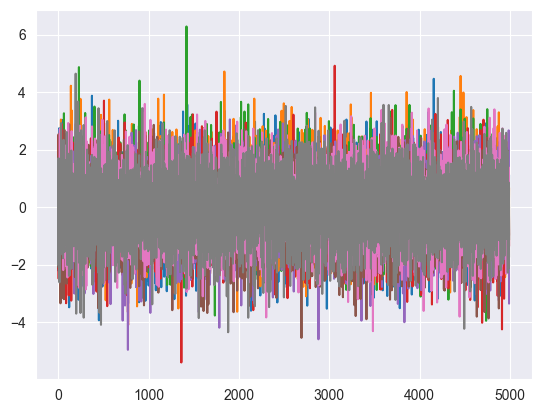

In [39]:
plt.plot(X_Homo)

In [40]:
np.savetxt("reconstructed_data_homo.csv", X_Homo, delimiter=",")

In [41]:
from statsmodels.stats.diagnostic import het_arch
from termcolor import colored
# Perform Engle's ARCH test for heteroscedasticity on the residuals
arch_test_resid = het_arch(X_Homo[:,0])

# Extract the test statistic and p-value
arch_stat_resid = arch_test_resid[0]
arch_p_value_resid = arch_test_resid[1]

print(f'ARCH Test Statistic: {arch_stat_resid}')
print(f'p-value: {arch_p_value_resid:.4f}')
if arch_p_value_resid > 0.05:
    print(colored("A p-value > 0.05 means that heteroscedasticity is no longer present in the residuals, indicating that VAE has successfully reduced it.",'red'))
else:
    print(f"VAE fail to reduce heteroscedasticity")

ARCH Test Statistic: 2.4782999454238452
p-value: 0.9912
A p-value > 0.05 means that heteroscedasticity is no longer present in the residuals, indicating that VAE has successfully reduced it.


In [42]:
from arch import arch_model

# Rescale the data (multiply by 100)
scaled_data = X_Homo[:,0] * 10

# Fit the GARCH model with rescaled data
garch_model = arch_model(scaled_data, vol='Garch', p=1, q=1)
garch_rescaled_fitted = garch_model.fit(disp="off")

# Summarize the model
print(garch_rescaled_fitted.summary())


# Forecasting future volatility with rescaled data
forecast = garch_rescaled_fitted.forecast(horizon=5)
forecast_variance_rescaled = forecast.variance[-1:] / 10  # Scale back
print(forecast_variance_rescaled)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -18567.0
Distribution:                  Normal   AIC:                           37142.1
Method:            Maximum Likelihood   BIC:                           37168.1
                                        No. Observations:                 4990
Date:                Fri, Sep 20 2024   Df Residuals:                     4989
Time:                        19:11:26   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu         6.1156e-03      0.141  4.324e-02      0.966 [ -0.271,  0.28

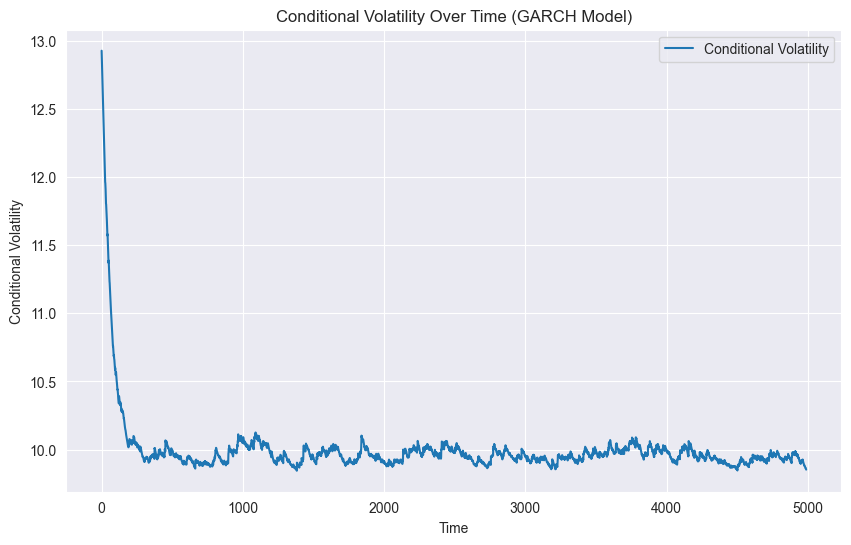

In [43]:

# Plot the conditional volatility over time (variance over time)
plt.figure(figsize=(10, 6))
# Plot the conditional volatility (square root of variance)
conditional_volatility = garch_rescaled_fitted.conditional_volatility
plt.plot(garch_rescaled_fitted.conditional_volatility, label='Conditional Volatility')
plt.title('Conditional Volatility Over Time (GARCH Model)')
plt.xlabel('Time')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
from kl.dichotomy_vae import DichotomyVAE, LossType
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime

# Example usage for fitting and transforming data
input_dim = X.shape[1]
vae_model = DichotomyVAE(input_dim=input_dim, output_dim=input_dim, latent_dim=4, num_classes=2, loss_type = LossType.Classifier, verbose=True)
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=5000)


# back to tensor because return numpy
X_Homo_Tensor = torch.tensor(X_Homo, dtype=torch.float)

# Create a DataLoader for batching
batch_size = 64
dataset = TensorDataset(X_Homo_Tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

start_time = datetime.now()
# Fit and transform
vae_model.fit(dataloader, optimizer, scheduler, num_epochs=5000, beta=1, lambda_class=1)

# Transform new data
# x_new = torch.tensor(X_new, dtype=torch.float32)
x_reconstructed, latent_representation, predicted_class = vae_model.transform(X_Homo_Tensor) 

end_time = datetime.now()
# Execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time}")

Using CPU
Epoch          0, kl: 16.2825, class: 0.6898, lr: 0.001000
Epoch        100, kl: 1834.1584, class: 0.6571, lr: 0.000980
Epoch        200, kl: 2582.8721, class: 0.5521, lr: 0.000960
Epoch        300, kl: 2999.6382, class: 0.4094, lr: 0.000940
Epoch        400, kl: 3117.1611, class: 0.3476, lr: 0.000920
Epoch        500, kl: 3746.7271, class: 0.3732, lr: 0.000900
Epoch        600, kl: 3625.6357, class: 0.3091, lr: 0.000880
Epoch        700, kl: 4206.3760, class: 0.3399, lr: 0.000860
Epoch        800, kl: 4181.0024, class: 0.2629, lr: 0.000840
Epoch        900, kl: 4788.4678, class: 0.4552, lr: 0.000820
Epoch       1000, kl: 4841.9756, class: 0.2439, lr: 0.000800
Epoch       1100, kl: 4712.5410, class: 0.2130, lr: 0.000780
Epoch       1200, kl: 5439.3877, class: 0.1255, lr: 0.000760
Epoch       1300, kl: 5306.9814, class: 0.1549, lr: 0.000740
Epoch       1400, kl: 5393.4849, class: 0.2311, lr: 0.000720
Epoch       1500, kl: 5323.1338, class: 0.1380, lr: 0.000700
Epoch       1600

In [ ]:
x_reconstructed_np = x_reconstructed.cpu().detach().numpy()
np.savetxt("x_reconstructed_np.csv", x_reconstructed_np, delimiter=",")

latent_representation_np = latent_representation.detach().cpu().numpy()
np.savetxt("latent_representation_np.csv", latent_representation_np, delimiter=",")

predicted_class_np = predicted_class.cpu().detach().numpy()
np.savetxt("predicted_class_np.csv", predicted_class_np, delimiter=",")

np.savetxt("real_class_np.csv", y, delimiter=",")

In [ ]:
print(f'Class Mean: {np.mean(predicted_class_np)}')

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
acc = accuracy_score(y, predicted_class_np)
print(f"Train Accuracy: {acc}")

In [ ]:
# visualize the embedding
from sklearn. preprocessing import StandardScaler
scaler = StandardScaler()
latent_representation_np = scaler.fit_transform(latent_representation_np)
if np.shape(latent_representation)[1] == 3:
    fig, _ = plt.subplots(1, 1, figsize=(6, 6))
    ax = plt.axes(projection ="3d")
    ax.scatter(latent_representation_np[:, 0], latent_representation_np[:, 1], latent_representation_np[:, 2], cmap="autumn", c=y, s=20)
elif np.shape(latent_representation)[1] == 2:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(latent_representation_np[:, 0], latent_representation_np[:, 1], cmap="autumn", c=y, s=20)   
else:
    print("Can Not Plot Latent Representation. Dimensions Mismatch")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(latent_representation_np[:, 0], bins=50, color='r')
ax.hist(latent_representation_np[:, 1], bins=50, color='y')
# ax.hist(latent_representation_np[:, 2], bins=50, color='b')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(x_reconstructed_np[:, 0], bins=50, color='r')
ax.hist(x_reconstructed_np[:, 1], bins=50, color='y')
ax.hist(x_reconstructed_np[:, 2], bins=50, color='b')
ax.hist(x_reconstructed_np[:, 3], bins=50, color='r')
ax.hist(x_reconstructed_np[:, 4], bins=50, color='y')
#ax.hist(x_reconstructed_np[:, 5], bins=50, color='b')
#ax.hist(x_reconstructed_np[:, 6], bins=50, color='r')
# ax.hist(x_reconstructed_np[:, 7], bins=50, color='y')

In [ ]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(x_reconstructed_np)
# df = pd.DataFrame(latent_representation_np)
corr = df.corr()
sns.heatmap(corr, annot = True)
plt.show()

In [ ]:
from sklearn.feature_selection import mutual_info_classif
mutual_info_classif(latent_representation_np, y)
# mutual_info_classif(x_reconstructed_np, y)


In [ ]:
from sklearn.decomposition import PCA
# pca = PCA(n_components=3)
# pca.fit(latent_representation_np)
pca = PCA(n_components=8, )
pca.fit(x_reconstructed_np)

print(pca.explained_variance_ratio_)